In [109]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from utils.plotting import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from scipy.sparse import coo_matrix, find
from django.db.models import Q, F, Sum, Count, FloatField, Case, When

from run_id import run_id
run_id = 662
stat = RunStats.objects.get(pk=run_id)
parent_run_id = stat.parent_run_id
q = stat.query
print(q.title)
from tmv_app.tasks import *
from utils.text import *

wos_all_updated


In [15]:
def check_phrase(phrase):

    doc_ids = set(list(DocTopic.objects.filter(
        run_id=parent_run_id
    ).values_list('doc_id',flat=True)))

    phrase_years = []

    for p in stat.periods.order_by('n'):
        ydocs = Doc.objects.filter(
                    pk__in=doc_ids,
                    PY__in=p.ys
                )
        yn = ydocs.count()
        yphrase = ydocs.filter(content__iregex=phrase).count()
        phrase_years.append({
            'AP': p.title,
            'yn': yn,
            phrase: yphrase
        })
    return pd.DataFrame.from_dict(phrase_years)

In [47]:
p = Project.objects.get(title="NETs")
pdocs = Doc.objects.filter(query__project=p) | Doc.objects.filter(technology__project=p)

ne_ids = set(list(pdocs.filter(docownership__relevant=1).values_list('id',flat=True)))

ne_docs = Doc.objects.filter(id__in=ne_ids)

phrase_years = []

for p in stat.periods.order_by('n'):
    ydocs = Doc.objects.filter(
                pk__in=doc_ids,
                PY__in=p.ys,
                PY__lt=2017
            )
    yn = ydocs.count()
    #yphrase = ne_docs.filter(PY__in=p.ys).count()
    yphrase = ydocs.filter(id__in=ne_ids).count()
    phrase_years.append({
        'AP': p.title,
        'yn': yn,
        'ne': yphrase
    })
ne = pd.DataFrame.from_dict(phrase_years)

In [48]:
ne['share'] = ne['ne'] / ne['yn'] * 100
ne.head(6)

,AP,ne,yn,share
0,AR1,0,264,0.000000
1,AR2,28,5801,0.482675
2,AR3,46,16750,0.274627
3,AR4,201,40141,0.500735
4,AR5,612,101654,0.602042
5,AR6,546,89453,0.610376


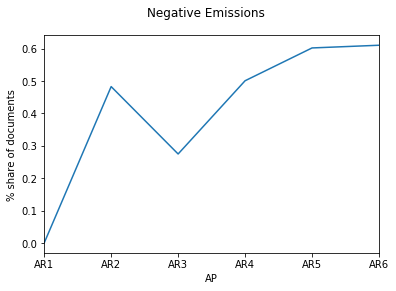

In [79]:
ne[['AP','share']].set_index('AP').plot(legend=None)
plt.ylabel('% share of documents')

plt.suptitle("Negative Emissions")
plt.savefig('../plots/negative_emissions_share.png'.format(run_id),bbox_inches='tight')

plt.show()

In [16]:
phrase = "negative emission|carbon dioxide removal"

df = check_phrase(phrase)
df.head()

,AP,negative emission|carbon dioxide removal,yn
0,AR1,0,264
1,AR2,5,5801
2,AR3,8,16750
3,AR4,10,40141
4,AR5,72,101654


In [20]:
df['share'] = df['negative emission|carbon dioxide removal'] / df['yn']
df.head(6)

,AP,negative emission|carbon dioxide removal,yn,share
0,AR1,0,264,0.000000
1,AR2,5,5801,0.000862
2,AR3,8,16750,0.000478
3,AR4,10,40141,0.000249
4,AR5,72,101654,0.000708
5,AR6,113,124708,0.000906


In [58]:
sus = check_phrase("research|sustain|social")

,AP,negative emission|carbon dioxide removal,yn,share
0,AR1,0,264,0.000000
1,AR2,5,5801,0.000862
2,AR3,8,16750,0.000478
3,AR4,10,40141,0.000249
4,AR5,72,101654,0.000708


In [77]:
sus['share'] = sus["research|sustain|social"] / sus['yn'] * 100
sus.head(6)

,AP,research|sustain|social,yn,share
0,AR1,19,264,7.196970
1,AR2,666,5801,11.480779
2,AR3,2142,16750,12.788060
3,AR4,5719,40141,14.247278
4,AR5,21232,101654,20.886537
5,AR6,29722,124708,23.833275


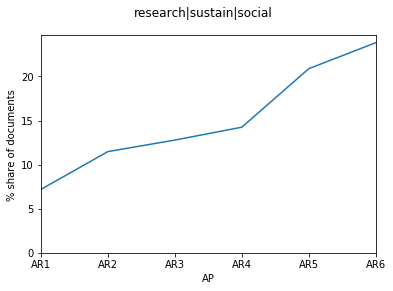

In [78]:
sus[['AP','share']].set_index('AP').plot(legend=None)
plt.ylabel('% share of documents')
plt.ylim(ymin=0)
plt.suptitle("research|sustain|social")
plt.savefig('../plots/sus_share.png'.format(run_id),bbox_inches='tight')

plt.show()

In [72]:
phrase = "aerosol|forcing"
aero = check_phrase(phrase)


In [75]:
aero['share'] = aero[phrase] / aero['yn'] * 100
aero.head(6)

,AP,aerosol|forcing,yn,share
0,AR1,31,264,11.742424
1,AR2,381,5801,6.567833
2,AR3,1296,16750,7.737313
3,AR4,3076,40141,7.662988
4,AR5,5441,101654,5.352470
5,AR6,5182,124708,4.155307


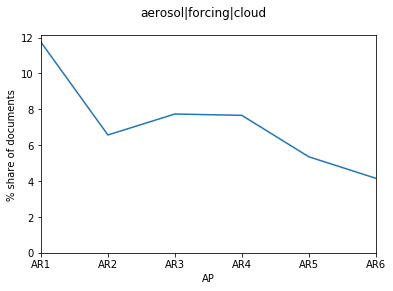

In [119]:
aero[['AP','share']].set_index('AP').plot(legend=None)
plt.ylabel('% share of documents')
plt.ylim(ymin=0)
plt.suptitle("aerosol|forcing|cloud")
plt.savefig('../plots/aero_share.png'.format(run_id),bbox_inches='tight')

plt.show()

In [113]:
phrase = "migration"
migration = check_phrase(phrase)


In [117]:
migration['share'] = migration[phrase] / migration['yn'] * 100
migration.head(6)
migration.to_csv('../tables/migration.csv')

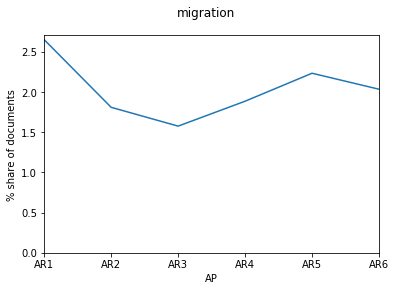

In [118]:
migration[['AP','share']].set_index('AP').plot(legend=None)
plt.ylabel('% share of documents')
plt.ylim(ymin=0)
plt.suptitle(phrase)
plt.savefig('../plots/migration.png'.format(run_id),bbox_inches='tight')

plt.show()

In [91]:
ip_shares = [
    
]

In [92]:
ipcounts = IPCCRef.objects.all().count()
ipaero = IPCCRef.objects.filter(text__iregex="aerosol|forcing|cloud").count()
ipshare = ipaero/ipcounts*100

doc_ids = set(list(DocTopic.objects.filter(
    run_id=parent_run_id
).values_list('doc_id',flat=True)))

docs = Doc.objects.filter(id__in=doc_ids).count()
aerodocs = Doc.objects.filter(id__in=doc_ids,title__iregex="aerosol|forcing|cloud").count()

docshare = aerodocs / docs * 100

ip_shares.append({
    'words': "aerosol|forcing|cloud",
    'ipshare': ipshare,
    'docshare': docshare
})

print(ipshare)
print(docshare)

4.780946940329973
1.5467409563179615


In [93]:
ipcounts = IPCCRef.objects.all().count()
ipaero = IPCCRef.objects.filter(text__iregex="carbon capture").count()
ipshare = ipaero/ipcounts*100

doc_ids = set(list(DocTopic.objects.filter(
    run_id=parent_run_id
).values_list('doc_id',flat=True)))

docs = Doc.objects.filter(
    id__in=doc_ids,
    PY__lt=2014
).count()
aerodocs = Doc.objects.filter(
    id__in=doc_ids,
    title__iregex="carbon capture",
    PY__lt=2014
).count()

docshare = aerodocs / docs * 100

ip_shares.append({
    'words': "carbon capture",
    'ipshare': ipshare,
    'docshare': docshare
})

print(ipshare)
print(docshare)

0.05576637967383469
0.23631614118218822


In [94]:
df = pd.DataFrame.from_dict(ip_shares)
df.head()

,docshare,ipshare,words
0,1.546741,4.780947,aerosol|forcing|cloud
1,0.236316,0.055766,carbon capture


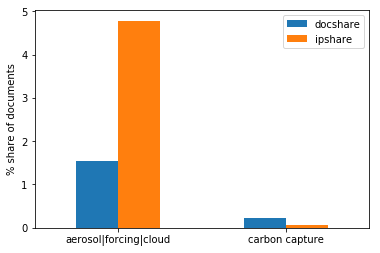

In [107]:
df.set_index('words').plot(kind="bar")
plt.xlabel('')
plt.ylabel('% share of documents')
plt.xticks(rotation=0)
plt.savefig('../plots/ipcc_rep_simple.png'.format(run_id),bbox_inches='tight')
plt.show()

In [110]:
ipcounts = IPCCRef.objects.all().count()
ipaero = IPCCRef.objects.filter(text__iregex="migration").count()
ipshare = ipaero/ipcounts*100

doc_ids = set(list(DocTopic.objects.filter(
    run_id=parent_run_id
).values_list('doc_id',flat=True)))

docs = Doc.objects.filter(
    id__in=doc_ids,
    PY__lt=2014
).count()
aerodocs = Doc.objects.filter(
    id__in=doc_ids,
    title__iregex="migration",
    PY__lt=2014
).count()

docshare = aerodocs / docs * 100

ip_shares.append({
    'words': "migration",
    'ipshare': ipshare,
    'docshare': docshare
})

print(ipshare)
print(docshare)

0.35908107887542334
0.3754328412611628


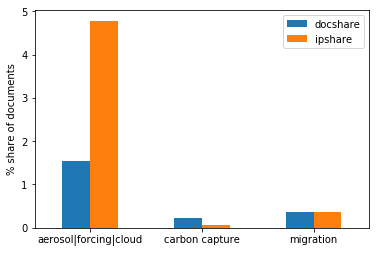

In [112]:
df = pd.DataFrame.from_dict(ip_shares)
df.head()

df.set_index('words').plot(kind="bar")
plt.xlabel('')
plt.ylabel('% share of documents')
plt.xticks(rotation=0)
plt.savefig('../plots/ipcc_rep_simple.png'.format(run_id),bbox_inches='tight')
plt.show()